# Afternoon Activity - Day 7

#### This notebook was developed by [Zeljko Ivezic](http://faculty.washington.edu/ivezic/) for the 2021 data science class at the University of Sao Paulo and it is available from [github](https://github.com/ivezic/SaoPaulo2021/blob/main/notebooks/Activity7.ipynb).

## Problem 1

Fit polynomials of up to the 5th order to the provided dataset.
Use BIC to find the best model for this dataset.

## Problem 2 

Apply Bayesian Blocks Algorithm to period distribution (logP) of LINEAR variable stars. 
Plot histograms on both linear and log scale. Compare the result to classical (Knuth's) 
uniform bin width histogram. 

## Problem 3

The flux vs. time plot further below shows UV flux measurements for an active M dwarf
star. These stars are known for their exponential bursts of energy, well described
by the profile 
$$\rm{flux(time)} = A\,exp(-\alpha \, t)$$ 
for $t>T$. Find how many bursts were observed for this star during the provided 2 hour 
stretch of data and estimate their amplitudes (A), decay constants ($\alpha$),
and the time of bursts. 

**Hints:**
- there are no more than 2 bursts in this dataset
- you can use flat priors for A and T and the background (non-bursting) flux level,
  and Jeffreys' prior for $\alpha$
- you can do approximate model comparison based on the BIC 
- you can relatively easily solve this problem by generalizing the code from [fig. 10.25](http://www.astroml.org/book_figures/chapter10/fig_matchedfilt_burst.html)

### Some useful definitions and functions

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from astroML.datasets import fetch_LINEAR_geneva
from astroML.plotting import setup_text_plots
from astroML.plotting import hist
setup_text_plots(fontsize=12, usetex=True)

## Problem 1: use BIC to find the best polynomial model for a given dataset

## Bayesian Statistical Inference

In Bayesian inference, we evaluate the **posterior probability** by using
** data likelihood** and **prior** information: 
 
$$p(M,\theta \,|\,D,I) = \frac{p(D\,|\,M,\theta,I)\,p(M,\theta\,|\,I)}{p(D\,|\,I)},$$

The prior can be expanded as 
$$p(M,\theta\,|\,I) = p(\theta\,|\,M,I)\,p(M\,|\,I).$$
 
It is often the case that $p(D\,|\,I)$ is not evaluated explictly since the posterior probability 
can be (re)normalized. 

**The Bayesian Statistical Inference process** is then
* formulate the likelihood, $p(D\,|\,M,\theta,I)$
* chose a prior $p(M,\theta\,|\,I)$, which incorporates *other information beyond the data in $D$*
* determine the posterior pdf, $p(M,\theta \,|\,D,I)$
* search for the model parameters that maximize $p(M,\theta \,|\,D,I)$ 
* quantify the uncertainty of the model parameter estimates (credible region)
 
 
### Bayesian Model Comparison

To determine which model is better we compute the ratio of the posterior probabilities or the **odds ratio** for two models as
$$O_{21} \equiv \frac{p(M_2|D,I)}{p(M_1|D,I)}.$$

The posterior probability that the model $M$ is correct given data $D$ is
$$p(M|D,I) = \frac{p(D|M,I)p(M|I)}{p(D|I)},$$
and the odds ratio can ignore $p(D|I)$ since it will be the same for both models. 

We get 
$$O_{21} = \frac{p(D\,|\,M_2,I)\,p(M_2\,|\,I)}{p(D\,|\,M_1,I)\,p(M_1\,|\,I)} \equiv B_{21} \, \frac{p(M_2\,|\,I)}{p(M_1\,|\,I)},$$
where $B_{21}$ is called the Bayes factor. 

The Bayes factor compares how well the models fit the data: it is a ratio of data likelihoods averaged over 
all allowed values of the model parameters and computed as
$$B_{21} = \frac{\int p(D\,|\,M_2, \theta, I) \, p(\theta\,|\,M_2, I) \, d\theta}{\int p(D\,|\,M_1, \theta, I) \, p(\theta\,|\,M_1, I) \, d\theta}. $$
 
In other words, the Bayes factor is the ratio of **the global likelihoods for models $M_1$ and $M_2$**, 
where the global likelihood, or evidence, is a weighted average of the likelihood function, with the 
prior for model parameters acting as the weighting function.

N.B. To get the best-fit model parameters, we take a derivative of the product of the likelihood function
and priors (and equate it to 0), while to get the global likelihood we integrate it. 
 
**How do we interpret the values of the odds ratio, $O_{21}$, in practice?**

Jeffreys proposed a five-step scale for 
interpreting the odds ratio, where $O_{21} > 10$ represents “strong” evidence in favor of $M_2$ ($M_2$ 
is ten times more probable than $M_1$; analogously $O_{21} < 0.1$ is “strong” evidence in favor of $M_1$), 
and $O_{21} > 100$ is “decisive” evidence ($M_2$ is one hundred times more probable than $M_1$). 
When $O_{21} < 3$, the evidence is “not worth more than a bare mention.”

### Approximate Bayesian Model Comparison

The data likelihood, required to compute the models odds ratio, and the commonly 
used $\chi^2$ goodness-of-fit parameter are related. By introducting a few 
assumptions and approximations, the computations of the odds ratio can be
greatly simplified and expressed as the sum of $\chi^2$ and a term that penalizes
models for their parameters (when models achieve similar values of $\chi^2$,
the one with the smallest number of free parameters wins). 
 
We consider a one dimensional case with unknown parameter $\mu$ and
start with an approximate computation of the evidence $E(M)$,
$$ E(M) = \int p(\{x_i\}, \,|\,M, \mu, I) \, p(\mu \,|\,M, I) \, d \mu .$$

Our first assumption is that the prior is uniform 
$$  p(\mu\,|\, M, I) = \frac{1}{\Delta} \,\,\,\,\,\, {\rm for} \,\,\, -\frac{\Delta}{2} < \mu < \frac{\Delta}{2}$$
and 0 otherwise. 

The second assumption is that the data likelihood can
be approximated as a Gaussian around its maximum at $\mu=\mu_0$
$$ p(\{x_i\} \,|\,M, \mu, I) \approx L(\mu_0) \, \exp \left( - \frac{(\mu - \mu_0)^2}{2 \sigma_\mu^2} \right). $$

These assumptions lead to 
$$ E(M) \approx \frac{L(\mu_0)}{\Delta} \, \int_{-\Delta/2}^{\Delta/2} \exp \left( - \frac{(\mu - \mu_0)^2}{2 \sigma_\mu^2}\right) d\mu, $$
and with an additional assumption $\sigma_\mu \ll \Delta$ (data overcomes
the prior), we get
$$ E(M) \approx \frac{\sigma_\mu}{\Delta} \, L(\mu_0) \, \sqrt{2\pi}. $$

Note that $E(M) \ll L(\mu_0)$, because $\sigma_\mu \ll \Delta$. In multi-dimensional
case, each model parameter constrained by the model carries a similar 
multiplicative penalty, proportional to $\sigma_\mu/\Delta$, when computing the 
Bayes factor. If a parameter, or a degenerate parameter combination, is unconstrained 
by the data (i.e., $\sigma_\mu \approx \Delta$), there is no penalty.  
The odds ratio can justify an additional model parameter **only if this penalty is offset** by either 
an increase of the maximum value of the data likelihood, $L(\mu_0$), or by the ratio 
of prior model probabilities, $p(M_2|I)/p(M_1|I)$. If both of these quantities are 
similar for the two models, the one with fewer parameters typically wins.

If a model is well constrained by the data, for each of $k$ constrained
parameters, $\sigma_\mu \propto 1/\sqrt{N}$, where $N$ is the number of data 
points. Therefore,
$$ E(M) \propto L(\mu_0) \, \left(\sqrt{N}\right)^k. $$
 
In order to establish connection with $\chi^2$ via $L(\mu_0) =
\exp\left(-\frac{\chi^2}{2}\right)$, we define for a model the **Bayesian information 
criterion (BIC)** as $BIC \equiv -2\ln{E(M)}$, and finally obtain  
$${\rm BIC} = -2 \ln [L_0(M)] + k \ln N.$$ 
The 1st term on the RHS is equal to model's $\chi^2$ (under the assumption 
of normality; note that this is *not* $\chi^2$ per degree of freedom!) and 
the 2nd term on the RHS penalizes complex models relative to simple ones.

In summary, when multiple models are considered, their BIC values, computed as
$${\rm BIC} = \chi^2 + k \ln N,$$ 
where $N$ is the number of data points and $k$ is the number of constrained
model parameters, are compared and the model with the smallest BIC value wins.   
 
**N.B.** BIC is an approximation and might not be valid if the underlying 
assumptions (data ovecoming prior and Gaussian likelihood) are not met! In general, it is better to compute the odds ratio when computationally feasible.

   
 

##  How do we interpret BIC? 

**How do we interpret the values of the odds ratio in practice?**

Jeffreys proposed a five-step scale for interpreting the odds ratio, where $O_{21} > 10$ represents “strong” evidence in favor of $M_2$ ($M_2$ is ten times more probable than $M_1$), and $O_{21} > 100$ is “decisive” evidence ($M_2$ is one hundred times more probable than $M_1$). When $O_{21} < 3$, the evidence is “not worth more than a bare mention.”

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # set default plot styles
from scipy import stats
from scipy import optimize

# this function computes polynomial models given some data x
# and parameters theta
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, x, y, sigma_y, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    y_fit = model(theta, x)
    return sum(stats.norm.logpdf(*args)
               for args in zip(y, y_fit, sigma_y))

# a direct optimization approach is used to get best model 
# parameters (which minimize -logL)
def best_theta(degree, x, y, sigma_y, model=polynomial_fit):
    theta_0 = (degree + 1) * [0]
    neg_logL = lambda theta: -logL(theta, x, y, sigma_y, model)
    return optimize.fmin_bfgs(neg_logL, theta_0, disp=False)

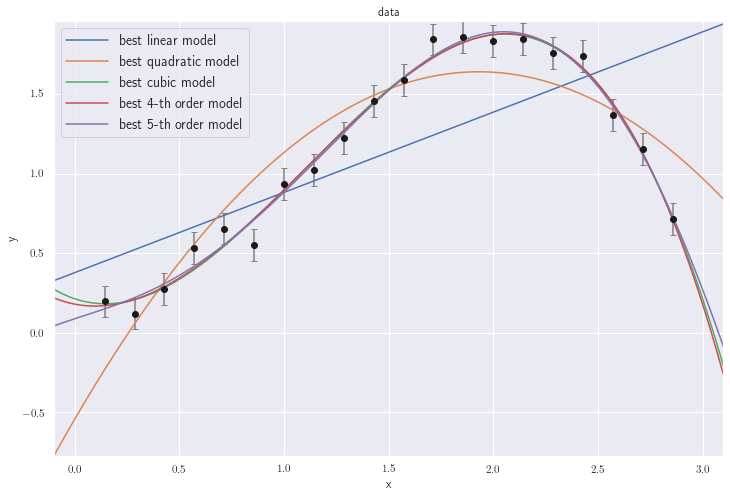

In [3]:
# generate (noisy) data
np.random.seed(0)
Ndata = 22
x = np.linspace(0, 3, Ndata)[1:-1]
sigma_y = 0.1 + 0*x
y = np.random.normal(np.sin(x) * x, sigma_y) 
# data = np.array([x, y, sigma_y])

# get best-fit parameters for linear, quadratic and cubic models
theta1 = best_theta(1, x, y, sigma_y)
theta2 = best_theta(2, x, y, sigma_y)
theta3 = best_theta(3, x, y, sigma_y)
theta4 = best_theta(4, x, y, sigma_y)
theta5 = best_theta(5, x, y, sigma_y)


# generate best fit lines on a fine grid 
xfit = np.linspace(-0.1, 3.1, 1000)
yfit1 = polynomial_fit(theta1, xfit)
yfit2 = polynomial_fit(theta2, xfit)
yfit3 = polynomial_fit(theta3, xfit)
yfit4 = polynomial_fit(theta4, xfit)
yfit5 = polynomial_fit(theta5, xfit)


# plot 
fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
ax.plot(xfit, polynomial_fit(theta1, xfit), label='best linear model')
ax.plot(xfit, polynomial_fit(theta2, xfit), label='best quadratic model')
ax.plot(xfit, polynomial_fit(theta3, xfit), label='best cubic model')
ax.plot(xfit, polynomial_fit(theta4, xfit), label='best 4-th order model')
ax.plot(xfit, polynomial_fit(theta5, xfit), label='best 5-th order model')

ax.legend(loc='best', fontsize=14)
ax.set(xlabel='x', ylabel='y', title='data');

In [4]:
# compute chi2 per degree of freedom: sum{[(y-yfit)/sigma_y]^2} 
chi21 = np.sum(((y-polynomial_fit(theta1, x))/sigma_y)**2) 
chi22 = np.sum(((y-polynomial_fit(theta2, x))/sigma_y)**2) 
chi23 = np.sum(((y-polynomial_fit(theta3, x))/sigma_y)**2) 
chi24 = np.sum(((y-polynomial_fit(theta4, x))/sigma_y)**2) 
chi25 = np.sum(((y-polynomial_fit(theta5, x))/sigma_y)**2) 


# the number of fitted parameters is 2, 3, 4, 5, 6
BIC1 = chi21 + 2*np.log(Ndata)
BIC2 = chi22 + 3*np.log(Ndata)
BIC3 = chi23 + 4*np.log(Ndata)
BIC4 = chi24 + 5*np.log(Ndata)
BIC5 = chi25 + 6*np.log(Ndata)


print ("         MODEL             CHI2          BIC")
print ('    best linear model:', chi21, BIC1)
print (' best quadratic model:', chi22, BIC2)
print ('     best cubic model:', chi23, BIC3)
print ('best 4-th order model:', chi24, BIC4)
print ('best 5-th order model:', chi25, BIC5)
print ("")
print ("Therefore, the cubic model is the winner!")

         MODEL             CHI2          BIC
    best linear model: 349.65913513675673 355.84122004347336
 best quadratic model: 99.33135251840808 108.60447987848303
     best cubic model: 10.182096497786729 22.546266311219995
best 4-th order model: 10.090493155738752 25.545705422530332
best 5-th order model: 9.753601458573456 28.299856178723353

Therefore, the cubic model is the winner!


## Problem 2
Compare Bayesian Blocks Algorithm and classsical histogram
on a sample of periodic variable stars.

In [5]:
# fetch data
data = fetch_LINEAR_geneva()
x = data['logP']
N = x.size

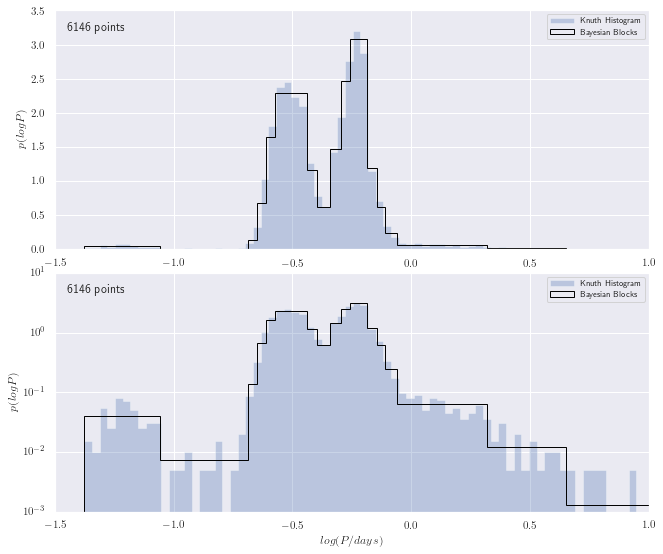

In [6]:
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)

# linear scale
ax = fig.add_subplot(211)
hist(x, bins='knuth', ax=ax, density=True,  
         histtype='stepfilled', alpha=0.3,
         label='Knuth Histogram')
hist(x, bins='blocks', ax=ax, density=True,  
         histtype='step', color='black', alpha=0.99,
         label="Bayesian Blocks")
# label the plot
ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)
ax.set_ylabel('$p(logP)$')
ax.legend(loc='upper right', prop=dict(size=8))

ax.set_xlim(-1.5, 1.0)
ax.set_ylim(0, 3.5)

# log scale
ax = fig.add_subplot(212)
hist(x, bins='knuth', ax=ax, density=True, log=True,
         histtype='stepfilled', alpha=0.3,
         label='Knuth Histogram')
hist(x, bins='blocks', ax=ax, density=True, log=True,
         histtype='step', color='black', alpha=0.99,
         label="Bayesian Blocks")
# label the plot
ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)
ax.set_ylabel('$p(logP)$')
ax.legend(loc='upper right', prop=dict(size=8))

ax.set_xlabel('$log(P/days)$')
ax.set_xlim(-1.5, 1.0)
ax.set_ylim(0.001, 10)

plt.show()



## Problem 3

Find out how many bursts in an active M dwarf light curve, and their best-fit model parameters.

In [7]:
def OneBurst(t, b0, A, T, alpha):
    """a single exponential burst model"""
    yBurst = A * np.exp(-(t-T)/alpha)
    return np.where(t > T, b0+yBurst, b0)

def TwoBursts(t, b0, A1, T1, alpha1, A2, T2, alpha2):
    """two exponential bursts model"""
    yBurst1 = A1 * np.exp(-(t-T1)/alpha1)
    yBurst2 = A2 * np.exp(-(t-T2)/alpha2)
    y1 = np.where(t > T1, b0+yBurst1, b0)
    return np.where(t > T2, y1+yBurst2, y1)

In [8]:
np.random.seed(42)

# BURST: input model parameters 
b0_true = 10
A1_true = 4
T1_true = 20
alpha1_true = 10
A2_true = 5
T2_true = 70
alpha2_true = 5

# generate data
Ndata = 200
t = 120 * np.random.random(Ndata)
xdata = np.sort(t) 
y_true = TwoBursts(xdata, b0_true, A1_true, T1_true, alpha1_true, A2_true, T2_true, alpha2_true)
thetaTrue = (b0_true, A1_true, T1_true, alpha1_true, A2_true, T2_true, alpha2_true)

# add scatter to points
yErr = 0.4 + 0.1*np.sqrt(y_true)    # worked with 0.2, 0.4, died with 0.5
ydata = np.random.normal(y_true, yErr)

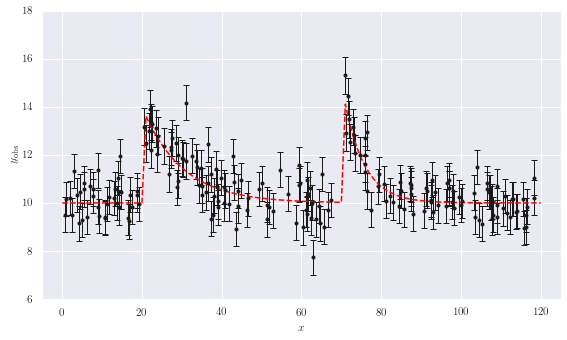

In [9]:
# Plot input data again, this time showing the true generative model
#  (which at the same time checks that the model and true params are set properly)
fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 120, 121)
y_true = TwoBursts(t_fit, b0_true, A1_true, T1_true, alpha1_true, A2_true, T2_true, alpha2_true)

ax.errorbar(xdata, ydata, yErr, fmt='.', lw=1, c='k')
ax.plot(t_fit, y_true, '--', c='red')
ax.set_xlim(-5, 125)
ax.set_ylim(6.0, 18.001)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$y_{\rm obs}$')

plt.show()

In [10]:
# Define our posterior using Python functions
# for clarity, I've separated-out the prior and likelihood
# but this is not necessary. Note that emcee requires log-posterior

def yModelSingle(x, theta):
    # this is where a model is chosen, and also the number 
    # of model parameters and their meaning set 
    b0 = theta[0]
    A = theta[1]
    T = theta[2]
    alpha = theta[3]
    return OneBurst(x, b0, A, T, alpha) 

def yModelDouble(x, theta):
    # this is where a model is chosen, and also the number 
    # of model parameters and their meaning set 
    b0 = theta[0]
    A1 = theta[1]
    T1 = theta[2]
    alpha1 = theta[3]
    A2 = theta[4]
    T2 = theta[5]
    alpha2 = theta[6]
    return TwoBursts(x, b0, A1, T1, alpha1, A2, T2, alpha2) 

def yModel(x, theta):
    return yModelDouble(x, theta)

LOGPRIOR_MIN = -np.inf 
#LOGPRIOR_MIN = -1.0e12

def log_flat_prior(theta, thetaMin, thetaMax):
    # logPriorMin = -np.inf  
    for k in range(np.size(theta)):
        if (theta[k]<thetaMin[k]): return LOGPRIOR_MIN 
        if (theta[k]>thetaMax[k]): return LOGPRIOR_MIN   
    return 1.0 
    
def log_prior(theta, thetaMin, thetaMax):
    return log_flat_prior(theta, thetaMin, thetaMax)

def log_likelihood(theta, x, y, yErr):
    # we are assuming that measurement errors are Gaussian and known
    # and thus ignoring normalization factors in the likelihood
    return -np.sum((y - yModel(x, theta)) ** 2 / yErr ** 2)

def log_posterior(theta, x, y, yErr, thetaMin, thetaMax):
    logLikelihood = log_likelihood(theta, x, y, yErr)
    logPrior = log_prior(theta, thetaMin, thetaMax)
    if logPrior > LOGPRIOR_MIN:
        return logPrior + logLikelihood
    else:
        return LOGPRIOR_MIN + logLikelihood 

In [11]:
# limits for flat priors
thetaMin =  (5,  0,  0,  2,  0,  20,  2)
thetaMax = (15, 10, 80, 20, 10, 100, 20)

# emcee combines multiple "walkers", each of which is its own MCMC chain. 
# The number of trace results will be nwalkers * nsteps
ndim = 7  # number of parameters in the model
nwalkers = 100  # number of MCMC walkers
# starting guesses for parameters 
np.random.seed(0)
starting_guesses = 0.1*np.random.random((nwalkers, ndim))
# set starting guesses at the center of flat priors
for k in range(np.size(thetaMin)):
    starting_guesses[:,k] += 0.5*(thetaMin[k]+thetaMax[k])

In [12]:
import emcee

In [13]:
nburn = 2000    # "burn-in" period to let chains stabilize
nsteps = 10000  # number of MCMC steps to take, about 1 min runtime
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[xdata, ydata, yErr, thetaMin, thetaMax])
%time sampler.run_mcmc(starting_guesses, nsteps) 
print("done")

CPU times: user 48.4 s, sys: 172 ms, total: 48.6 s
Wall time: 48.7 s
done


In [14]:
emcee_trace = sampler.chain[:, nburn:, :].reshape(-1, ndim).T
thetaFit= []
for k in range(ndim):
    thetaFit.append(np.median(emcee_trace[k]))
    print(thetaTrue[k], np.median(emcee_trace[k]), np.std(emcee_trace[k]), np.size(emcee_trace[k]))

10 10.052494028598357 0.18857897718545916 800000
4 3.7120116836445067 2.1409566445606147 800000
20 20.061514239386195 16.791090966395352 800000
10 10.920435747106616 2.832618607488798 800000
5 5.584191576868323 2.296202397219586 800000
70 68.45471872912032 15.261795251090113 800000
5 5.171399112331022 2.2883995754828588 800000


In [15]:
T1 = emcee_trace[2]
print(np.min(T1), np.median(T1), np.max(T1))

19.34655510645063 20.061514239386195 70.84244251852176


In [16]:
T2 = emcee_trace[5]
print(np.min(T2), np.median(T2), np.max(T2))

20.00025385700893 68.45471872912032 70.90714481175891


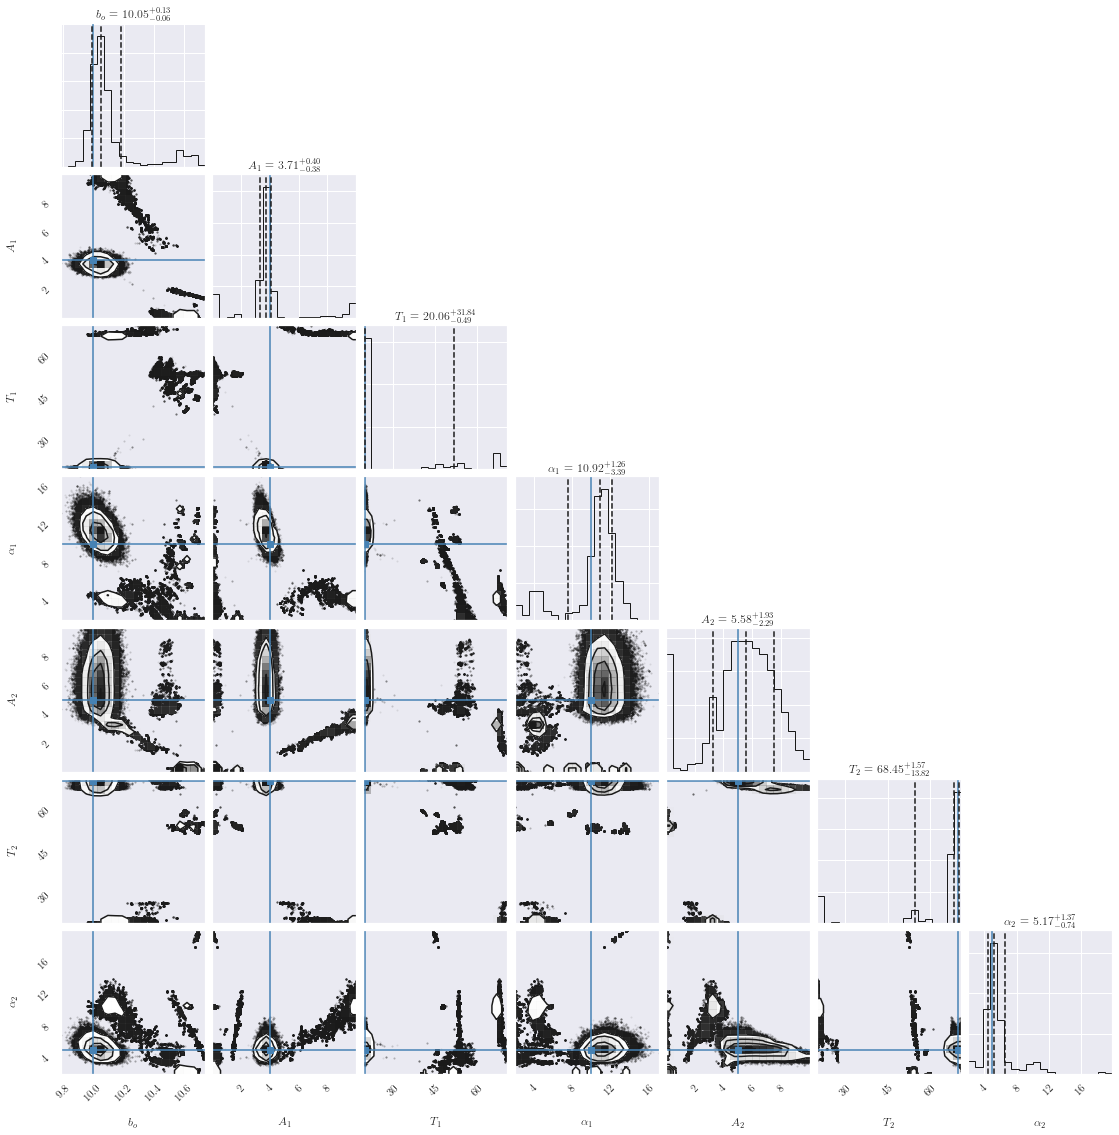

In [17]:
import corner
samples = np.vstack([emcee_trace[k] for k in range(0,ndim)]).T
Ls = [r"$b_o$", r"$A_1$", r"$T_1$", r"$\alpha_1$", r"$A_2$", r"$T_2$", r"$\alpha_2$"]  
corner.corner(samples, truths=thetaTrue, labels=Ls, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12});

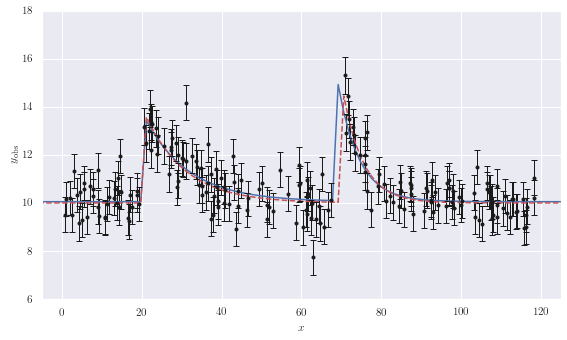

In [18]:
# Plot input data again, this time showing the true generative model
#  (which at the same time checks that the model and true params are set properly)
fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])

xfit = np.linspace(-10,130,100)
yfit = yModel(xfit, thetaFit)
yTrue = yModel(xfit, thetaTrue)
plt.plot(xfit, yfit, c='b')
plt.plot(xfit, yTrue,  '--', c='r')

ax.errorbar(xdata, ydata, yErr, fmt='.', lw=1, c='k')
ax.set_xlim(-5, 125)
ax.set_ylim(6.0, 18.001)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$y_{\rm obs}$')

plt.show()

## Now **you** need to: 
#### 1) find the best fit for a single-burst model
#### 2) compare BIC for the two models and decide which one is better


In [19]:
## we will need best fit for both models, so let's store the double-burst fit just in case...
thetaFitDoubleBurst = thetaFit
yfitDoubleBurst = yModel(xdata, thetaFitDoubleBurst)
chi2DoubleBurst = np.sum(((ydata-yfitDoubleBurst)/yErr)**2) 
NparamDoubleBurst = 7
BICdb = chi2DoubleBurst + NparamDoubleBurst *np.log(np.size(xdata))
print('Double Burst: chi2 =', chi2DoubleBurst, 'BIC =', BICdb)

Double Burst: chi2 = 190.6230378950541 BIC = 227.71125946089035


## Let's redo emcee steps for single burst model...

In [20]:
# we will now fit "wrong" model to the same data (that was generated with a double-burst model)
def yModel(x, theta):
    return yModelSingle(x, theta)

In [21]:
# limits for flat priors
thetaMin =  (8,  0, 10,  2)
thetaMax = (12, 10, 80, 20)
ndim = 4

# starting guesses for parameters 
np.random.seed(0)
starting_guesses = 0.1*np.random.random((nwalkers, ndim))
# set starting guesses at the center of flat priors
for k in range(np.size(thetaMin)):
    starting_guesses[:,k] += 0.5*(thetaMin[k]+thetaMax[k])

In [22]:
nburn = 2000    # "burn-in" period to let chains stabilize
nsteps = 10000  # number of MCMC steps to take
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[xdata, ydata, yErr, thetaMin, thetaMax])
%time sampler.run_mcmc(starting_guesses, nsteps) 
print("done")

CPU times: user 34.8 s, sys: 83.6 ms, total: 34.9 s
Wall time: 34.9 s
done


In [23]:
emcee_trace = sampler.chain[:, nburn:, :].reshape(-1, ndim).T
thetaFit= []
for k in range(ndim):
    thetaFit.append(np.median(emcee_trace[k]))
    print(thetaTrue[k], np.median(emcee_trace[k]), np.std(emcee_trace[k]), np.size(emcee_trace[k]))

10 10.395382664373326 0.09037853433047918 800000
4 3.879420930637398 2.140048373894537 800000
20 42.0270123300854 24.30910898280119 800000
10 7.146509467257802 3.217857872299367 800000


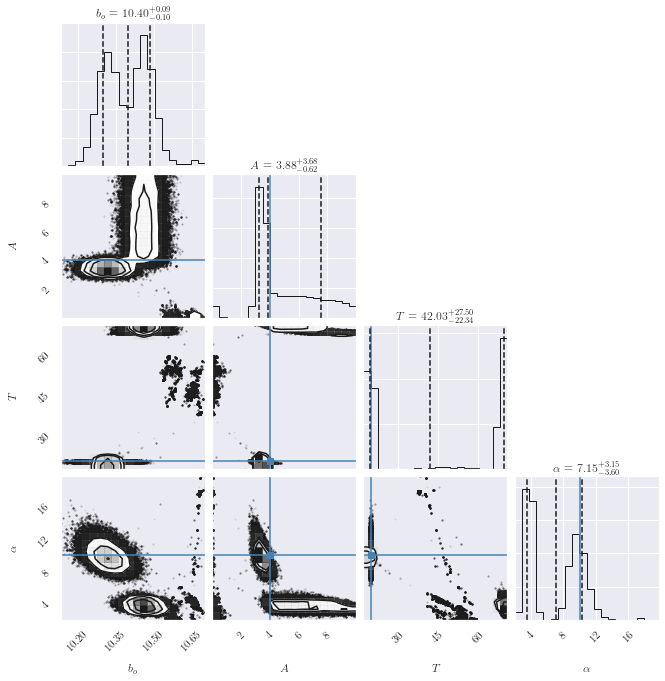

In [24]:
samples = np.vstack([emcee_trace[k] for k in range(0,ndim)]).T
Ls = [r"$b_o$", r"$A$", r"$T$", r"$\alpha$"]  
corner.corner(samples, truths=thetaTrue, labels=Ls, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12});

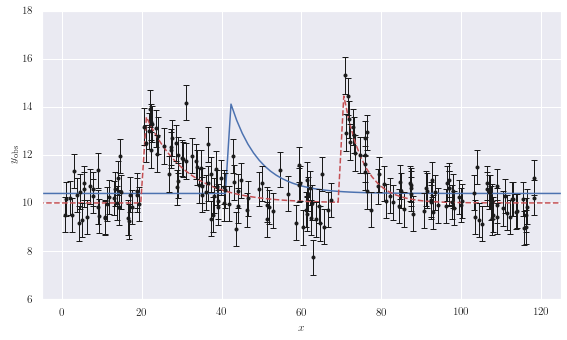

In [25]:
# Plot input data again, this time showing the true generative model
#  (which at the same time checks that the model and true params are set properly)
fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])

xfit = np.linspace(-10,130,100)
yfit = yModel(xfit, thetaFit)
plt.plot(xfit, yfit, c='b')
plt.plot(xfit, yTrue,  '--', c='r')

ax.errorbar(xdata, ydata, yErr, fmt='.', lw=1, c='k')
ax.set_xlim(-5, 125)
ax.set_ylim(6.0, 18.001)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$y_{\rm obs}$')

plt.show()

In [26]:
## let's evaluate chi2 and BIC for the single-burst fit 
thetaFitSingleBurst = thetaFit
yfitSingleBurst = yModel(xdata, thetaFitSingleBurst)
chi2SingleBurst = np.sum(((ydata-yfitSingleBurst)/yErr)**2) 
NparamSingleBurst = 4
BICsb = chi2SingleBurst + NparamSingleBurst *np.log(np.size(xdata))

In [27]:
print ("             MODEL                   CHI2            BIC")
print ('    best single burst model:', chi2SingleBurst, BICsb)
print ('    best double burst model:', chi2DoubleBurst, BICdb)

             MODEL                   CHI2            BIC
    best single burst model: 682.8098673402417 704.0031368064339
    best double burst model: 190.6230378950541 227.71125946089035
